In [5]:
# -*- coding: utf-8 -*

import os
import re
import json
import time
import warnings
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd

import mne
from scipy.signal import butter, filtfilt, detrend
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_curve, auc)
import matplotlib.pyplot as plt


In [ ]:
# -----------------------------------------------------------------------------
# Data Import & Preprocessing
# -----------------------------------------------------------------------------

def collect_eeg_data(folder_path: str) -> Dict[str, np.ndarray]:
    """Traverse *folder_path* and load every .set file with MNE."""
    data = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".set"):
            f_path = os.path.join(folder_path, filename)
            raw = mne.io.read_raw_eeglab(f_path, preload=True, verbose="CRITICAL")
            data[filename] = raw.get_data()
    return data


def read_json_dicts(file_path: str) -> pd.DataFrame:
    with open(file_path, "r", encoding="utf-8") as f:
        return pd.DataFrame(json.load(f))


def preprocess_eegnet_minimal(
        eeg_data: np.ndarray,
        fs: float,
        lowcut: float = 0.0,
        highcut: float = 0.0,
        order: int = 5) -> np.ndarray:
    
    n_channels, _ = eeg_data.shape
    processed = np.zeros_like(eeg_data)

    b, a = None, None
    if 0.0 < lowcut < highcut < fs / 2:
        nyq = 0.5 * fs
        b, a = butter(order, [lowcut / nyq, highcut / nyq], btype="band")

    for ch in range(n_channels):
        sig = eeg_data[ch]
        if b is not None and a is not None:
            sig = filtfilt(b, a, sig)
        mean, std = sig.mean(), sig.std()
        processed[ch] = (sig - mean) / (std if std > 1e-9 else 1.0)
    return processed


In [ ]:
# -----------------------------------------------------------------------------
# CNN
# -----------------------------------------------------------------------------

class Amini_Adapted_CNN(nn.Module):
    def __init__(self, n_channels: int, n_timesteps: int, num_classes: int,
                 dropout_rate: float = 0.5):
        super().__init__()
        self.conv1 = nn.Conv1d(
            in_channels=n_channels,
            out_channels=16,
            kernel_size=64,
            stride=16
        )
        self.bn1 = nn.BatchNorm1d(16)
        conv_out_steps = (n_timesteps - 64) // 16 + 1
        self.fc1 = nn.Linear(16 * conv_out_steps, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.drop = nn.Dropout(dropout_rate)

    def forward(self, x):  # x: (B, C, T)
        x = F.relu(self.bn1(self.conv1(x)))
        x = x.flatten(1)  # (B, *)
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        return self.fc3(x)


In [ ]:
# -----------------------------------------------------------------------------
# Train
# -----------------------------------------------------------------------------

def train_loop(model: nn.Module, loader: DataLoader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        loss = criterion(out, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = out.argmax(1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
    return total_loss / len(loader), 100.0 * correct / total


def eval_loop(model: nn.Module, loader: DataLoader, device, num_classes: int,
              class_names: List[str]):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = model(xb)
            prob = torch.softmax(out, 1)
            y_prob.append(prob.cpu().numpy())
            y_pred.append(out.argmax(1).cpu().numpy())
            y_true.append(yb.numpy())
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    y_prob = np.concatenate(y_prob)
    acc = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {acc*100:.2f}%")
    report = classification_report(y_true, y_pred, target_names=class_names,
                                   zero_division=0)
    print(report)
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
    auc_val = auc(fpr, tpr)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f"micro‑AUC={auc_val:.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.legend(); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC")
    plt.tight_layout(); plt.show()

In [ ]:
# -----------------------------------------------------------------------------
# build dataset
# -----------------------------------------------------------------------------

def get_base_filename(fn: str) -> str:
    return re.sub(r"_(amplitude_scale|noise|time_shift)(?=\.set$)", "", fn)


def build_dataset(
    folders: List[str],
    labels_json: str,
    fs: int = 95) -> Tuple[np.ndarray, np.ndarray, LabelEncoder]:
    """Load + preprocess all samples that have a label, return (X, y, le)."""
    # labels
    df_labels = read_json_dicts(labels_json)
    df_labels["file_name"] = df_labels["file_name"].str.replace(r"^(test/|train/)", "", regex=True)
    label_map = dict(zip(df_labels.file_name, df_labels.label))

    X_list, y_list = [], []
    for folder in folders:
        for fname, data in collect_eeg_data(folder).items():
            base = get_base_filename(fname)
            if base not in label_map:
                continue
            processed = preprocess_eegnet_minimal(data, fs)
            X_list.append(processed)
            y_list.append(label_map[base])

    if not X_list:
        raise RuntimeError("No samples were loaded — check folder paths and labels.json")

    X = np.stack(X_list)  # (N, C, T)
    le = LabelEncoder().fit(y_list)
    y = le.transform(y_list)
    return X, y, le


Loading & preprocessing … (this may take a while)
Total samples: 12419, shape per sample: (19, 1425)

Train: 9935, Test: 2484


—— Training on 80% train split ——
Epoch 001/100: loss=1.1040, acc=25.53%
Epoch 010/100: loss=0.9865, acc=45.51%
Epoch 020/100: loss=0.9768, acc=45.64%
Epoch 030/100: loss=0.9614, acc=45.85%
Epoch 040/100: loss=0.9648, acc=44.74%
Epoch 050/100: loss=0.9695, acc=45.95%
Epoch 060/100: loss=0.9618, acc=46.42%
Epoch 070/100: loss=0.9538, acc=47.38%
Epoch 080/100: loss=0.9607, acc=46.63%
Epoch 090/100: loss=0.9513, acc=48.18%
Epoch 100/100: loss=0.9505, acc=46.44%

—— Evaluating on 20% test split ——
Test Accuracy: 40.98%
              precision    recall  f1-score   support

           A       0.49      0.60      0.54      1041
           C       0.53      0.02      0.04       944
           F       0.32      0.76      0.45       499

    accuracy                           0.41      2484
   macro avg       0.45      0.46      0.34      2484
weighted avg       0.47  

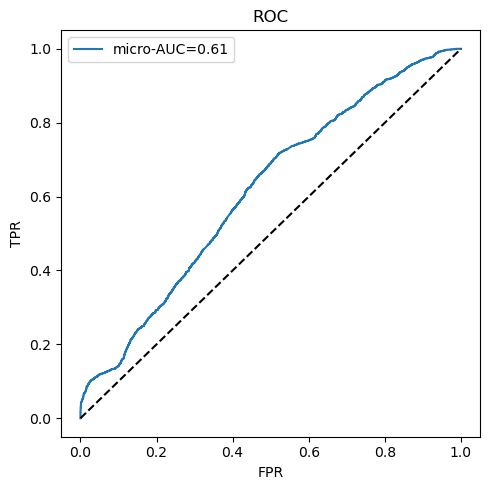


—— Re‑training on 100% data ——
[FULL] Epoch 001/100: loss=1.0906, acc=30.28%
[FULL] Epoch 010/100: loss=1.0028, acc=44.09%
[FULL] Epoch 020/100: loss=0.9686, acc=45.10%
[FULL] Epoch 030/100: loss=0.9683, acc=45.09%
[FULL] Epoch 040/100: loss=0.9803, acc=43.44%
[FULL] Epoch 050/100: loss=0.9887, acc=43.89%
[FULL] Epoch 060/100: loss=0.9729, acc=45.27%
[FULL] Epoch 070/100: loss=0.9683, acc=43.96%
[FULL] Epoch 080/100: loss=0.9749, acc=44.75%
[FULL] Epoch 090/100: loss=0.9570, acc=46.56%
[FULL] Epoch 100/100: loss=0.9625, acc=45.78%

Finished. Final model saved to ./eeg_cnn_full.pth


In [6]:
# -----------------------------------------------------------------------------
# Main pipeline
# -----------------------------------------------------------------------------

def run_pipeline(random_state: int = 42):
    # path
    folders = [
        "./fixed_data_aug/train",
        "./fixed_data_aug/validate",
        "./fixed_data_aug/test",
    ]
    labels_json = "./fixed_data_aug/labels.json"
    class_weight_dict = {0: 0.7941, 1: 0.8360, 2: 1.8364}

    # 1. build datasets
    print("Loading & preprocessing … (this may take a while)")
    X, y, le = build_dataset(folders, labels_json)
    print(f"Total samples: {X.shape[0]}, shape per sample: {X.shape[1:]}\n")

    # 2. Train/test split 8:2
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )
    print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}\n")

    # 3. DataLoader
    def make_loader(X_arr, y_arr, batch_size, shuffle):
        tensor_x = torch.from_numpy(X_arr).float()
        tensor_y = torch.from_numpy(y_arr).long()
        return DataLoader(TensorDataset(tensor_x, tensor_y), batch_size=batch_size, shuffle=shuffle)

    # best model configurations
    hp = {
        "weight_decay": 0.005963623316594642,
        "optimizer": "Adam",
        "num_epochs": 100,
        "learning_rate": 0.006579332246575682,
        "dropout_rate": 0.4242424242424242,
        "batch_size": 64,
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = make_loader(X_train, y_train, hp["batch_size"], True)
    test_loader  = make_loader(X_test,  y_test,  hp["batch_size"], False)

    n_channels, n_timesteps = X.shape[1], X.shape[2]
    num_classes = len(le.classes_)

    # 4. Train the model
    model = Amini_Adapted_CNN(n_channels, n_timesteps, num_classes, hp["dropout_rate"]).to(device)

    # class weights tensor
    cw_tensor = torch.tensor([class_weight_dict.get(i, 1.0) for i in range(num_classes)], dtype=torch.float32, device=device)

    criterion = nn.CrossEntropyLoss(weight=cw_tensor)
    optimizer = optim.Adam(model.parameters(), lr=hp["learning_rate"], weight_decay=hp["weight_decay"])

    print("\n—— Training on 80% train split ——")
    for epoch in range(1, hp["num_epochs"] + 1):
        loss, acc = train_loop(model, train_loader, criterion, optimizer, device)
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d}/{hp['num_epochs']}: loss={loss:.4f}, acc={acc:.2f}%")

    # 5. Evaluation
    print("\n—— Evaluating on 20% test split ——")
    eval_loop(model, test_loader, device, num_classes, le.classes_.tolist())

    # 6. Train the full model
    print("\n—— Re‑training on 100% data ——")
    full_loader = make_loader(X, y, hp["batch_size"], True)
    model_full = Amini_Adapted_CNN(n_channels, n_timesteps, num_classes, hp["dropout_rate"]).to(device)
    optimizer_full = optim.Adam(model_full.parameters(), lr=hp["learning_rate"], weight_decay=hp["weight_decay"])

    for epoch in range(1, hp["num_epochs"] + 1):
        loss, acc = train_loop(model_full, full_loader, criterion, optimizer_full, device)
        if epoch % 10 == 0 or epoch == 1:
            print(f"[FULL] Epoch {epoch:03d}/{hp['num_epochs']}: loss={loss:.4f}, acc={acc:.2f}%")

    # Save
    torch.save(model_full.state_dict(), "./eeg_cnn_full.pth")
    print("\nFinished. Final model saved to ./eeg_cnn_full.pth")


if __name__ == "__main__":
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    run_pipeline()
